In [1]:
%load_ext autotime
%load_ext sql
%matplotlib inline

from IPython.display import Image, display

import glob
import sqlite3
import sys
import warnings

import numpy as np
import pandas as pd
import sqlite3

sys.path.append("/home/czw/.local/lib/python3.6/site-packages/")
from astrowidgets import ImageWidget
import ipywidgets as widgets
import astropy.io.fits as FF
from astropy.table import QTable, hstack
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

import lsst.afw.image as afwImage
import lsst.daf.persistence as dafPersist
PROJ_DIR = '/project/czw/rc2_comp.20200217/'
SFM_DIR = '/datasets/hsc/repo/rerun/RC/w_2020_03/DM-23121-sfm/'
STK_DIR = '/datasets/hsc/repo/rerun/RC/w_2020_03/DM-23121/'
butler = dafPersist.Butler(STK_DIR)

plt.rcParams["figure.figsize"] = (20, 10)
warnings.filterwarnings('ignore')

# Comparison of the Pan-STARRS IPP (image processing pipeline; r40399) results to LSST "stack" processing (hereafter DRP; w_2020_03)
Why?
 * Both pipelines can operate on HSC data.
 * Look at independent checks on DRP results, using idential input data.
 * RC2 dataset (as defined https://jira.lsstcorp.org/browse/DM-11345)
 
Caveats:
 * Both processing uses the same reference catalog, so expect reasonable astrometric agreement.
 * Currently ignoring photometric calibration in favor of instrumental magnitude comparisons (the same measurement on the same data should yield the same results).
 * Differences in calibration products:
   * Did not remake BIAS/DARK/FLAT products in IPP to match DRP use.
   * IPP FLAT frames include star-flat correction.
 * No real effort to tune parameters to match (i.e. Background measurement boxes, stack input restrictions, etc.)
 * Running this notebook on LSP requires a 2core/4GB memory node.

In [2]:
# Load miscellaneous functions that are mostly important for generating the inputs
# for these dataframes (see accompanying notebook).
from rc2comp import *

time: 3.57 ms


### Read a database dump from IPP
 * Which exposures have been processed (ensures comparison code can find input catalogs).
 * Summary statistics from IPP processing.
 * Information about DRP Gen2 Butler registry to allow DRP catalogs to be fetched 

In [3]:
db = pq2df(PROJ_DIR + 'db.pqt')
db['visit'] = pd.to_numeric(db['visit'])
db.head()

,exp_name,exp_id,filter,object,exp_time,chip_id,state,label,data_group,fwhm_major,fwhm_minor,zpt_obs,visit,IPPSMF,pointing
0,HSC-0029340-000,5115,HSC-g,SSP-UDeep-COSMOS,300,5277,full,czwRC2.cosmos,czwRC2.cosmos.202200214,5.33356,4.95277,26.5486,29340,/project/czw/rc2_comp.20200217/czwRC2.cosmos.2...,1232
1,HSC-0029326-000,5116,HSC-g,SSP-UDeep-COSMOS,300,5278,full,czwRC2.cosmos,czwRC2.cosmos.202200214,6.14749,5.15847,26.6274,29326,/project/czw/rc2_comp.20200217/czwRC2.cosmos.2...,1232
2,HSC-0029350-000,5117,HSC-g,SSP-UDeep-COSMOS,300,5279,full,czwRC2.cosmos,czwRC2.cosmos.202200214,6.97560,6.41956,26.7444,29350,/project/czw/rc2_comp.20200217/czwRC2.cosmos.2...,1232
3,HSC-0029324-000,5118,HSC-g,SSP-UDeep-COSMOS,300,5280,full,czwRC2.cosmos,czwRC2.cosmos.202200214,5.74892,4.85371,26.5928,29324,/project/czw/rc2_comp.20200217/czwRC2.cosmos.2...,1232
4,HSC-0029336-000,5119,HSC-g,SSP-UDeep-COSMOS,300,5281,full,czwRC2.cosmos,czwRC2.cosmos.202200214,5.85303,5.11067,26.5876,29336,/project/czw/rc2_comp.20200217/czwRC2.cosmos.2...,1232


time: 120 ms


### Load prematched single-exposure/single-ccd catalogs
* Display the IPP processed CHIP/postISRCCD image.
* Region markers for
  * matched (blue circles)
  * IPP only (purple X)
  * DRP only (orange +)

In [4]:
matched = pq2df(PROJ_DIR + "try1/matched_chip/v0036408-008.pqt")
ippSolo = pq2df(PROJ_DIR + "try1/soloIPP/v0036408-008.pqt")
drpSolo = pq2df(PROJ_DIR + "try1/soloSRC/v0036408-008.pqt")

# Load image
IW = ImageWidget()
IW.load_fits(PROJ_DIR + 'example_chip/HSC-0036408-000.5114.ch.5022.x008.ch.fits')

# Create regions for detections in each group,
# rectifying the different orientation of chip x-axis:
IW.reset_markers()
IW.marker = {'type': 'plus', 'color': 'magenta', 'radius': 10}
try:
    IW.remove_markers('IPP')
except ValueError:
    pass
IW.add_markers(ippSolo, 'X_PSF', 'Y_PSF', marker_name='IPP')
IW.marker = {'type': 'cross', 'color': 'orange', 'radius': 10}
try:
    IW.remove_markers('DRP')
except ValueError:
    pass
drpSolo['X_ipp'] = 2048 - drpSolo['base_SdssCentroid_x']
IW.add_markers(drpSolo, 'X_ipp', 'base_SdssCentroid_y', marker_name='DRP')
IW.marker = {'type': 'circle', 'color': 'blue', 'radius': 5}
try:
    IW.remove_markers('MATCHED')
except ValueError:
    pass
IW.add_markers(matched, 'X_PSF', 'Y_PSF', marker_name='MATCHED')

# display image with regions
IW

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

time: 933 ms


## Quick False Positive Study:
 * Zoom in on the bright star at (RA, DEC) = (23:33:19, -01:00:56) with `middle-click`, `2`.
 * IPP false positives => cosmic rays
   * Uncorrected on images.
   * Detections are removed based on catalog parameters.
 * DRP false positives => split sources?
   * Fake objects around bright sources?
   * Is preferential "left side" density real?
 * Background effect?   

## Compare background models for this chip.
 * IPP supplies SKY measurement for each detection; local sky/background model value at detection center.
 * DRP does not, but this can be generated from the `calexpBackground` data product.

In [5]:
bkgModel = butler.get("calexpBackground", {'visit': 36408, 'ccd': 8})

time: 30.1 ms


In [6]:
matched[['base_SdssCentroid_x', 'base_SdssCentroid_y']]
drpSky = []
bkgImage = bkgModel.getImage()
for r in matched[['base_SdssCentroid_x', 'base_SdssCentroid_y']].values:
    u = int(r[0])
    v = int(r[1])
    bkg = bkgImage[u, v]
    drpSky.append(bkg)
matched['DRP_SKY'] = np.array(drpSky)

time: 479 ms


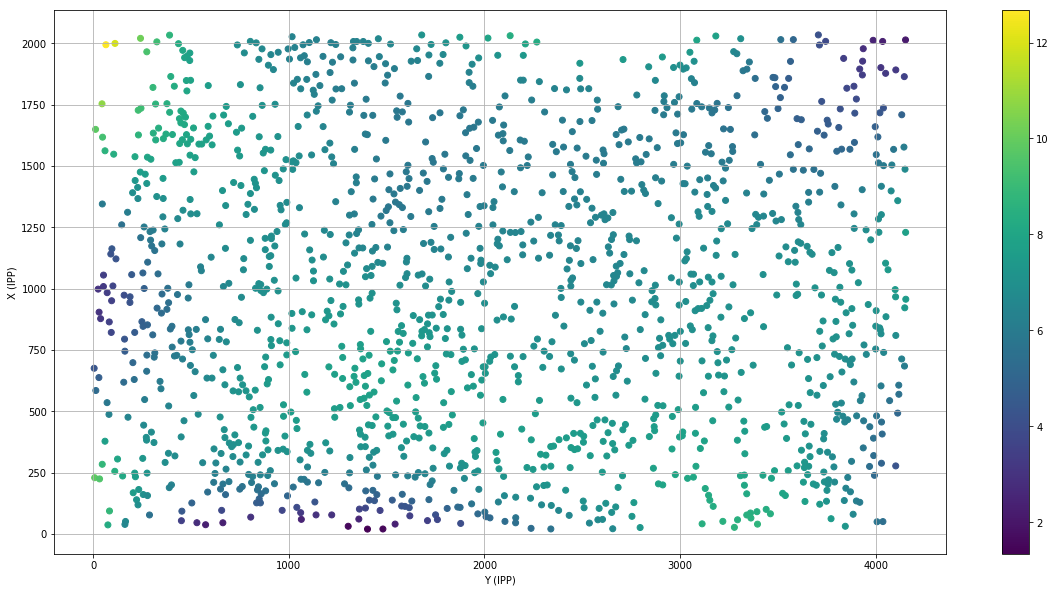

time: 785 ms


In [7]:
cm = plt.scatter(matched['Y_PSF'], matched['X_PSF'], c= matched['SKY'] - matched['DRP_SKY'])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("Y (IPP)")
plt.ylabel("X (IPP)")
plt.show()

### That doesn't answer much, does it?
 * (Note the rotation to better fit the notebook page).
 * Peak-to-peak difference of ~10 counts on ~2000 count backgrounds.
 * Both measurements are doing essentially the same thing.
 * No bright star print through at this level.
 * Differences largely around edges; says something about extrapolation?

## Astrometry from single chips: good to .1 arcsecond?

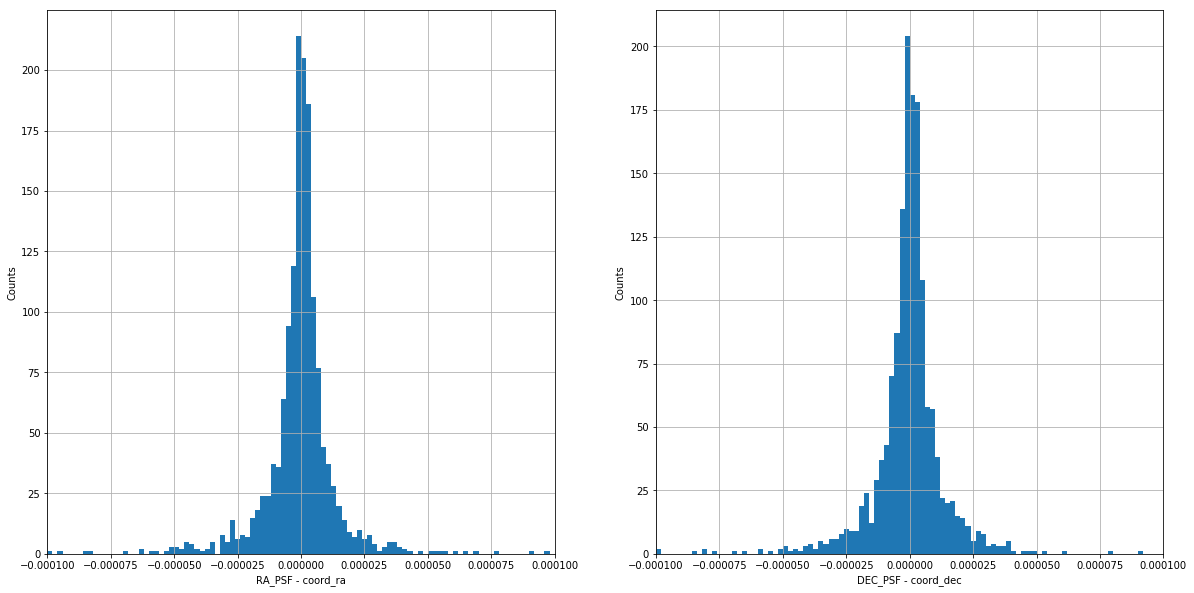

time: 907 ms


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
makeHistPlot(matched, 'RA_PSF', 'coord_ra', yf=(180.0 / np.pi), xlim=range4, fig=fig, ax=ax1)
makeHistPlot(matched, 'DEC_PSF', 'coord_dec', yf=(180.0 / np.pi), xlim=range4, fig=fig, ax=ax2)
fig.show()

### Make uncalibrated instrumental magnitudes for matched measurements

In [9]:
matched['PSF_INST_MAG'] = -2.5 * np.log10(matched['PSF_INST_FLUX'])
matched['KRON_MAG'] = -2.5 * np.log10(matched['KRON_FLUX'])

matched['base_PsfFlux_instMag'] = -2.5 * np.log10(matched['base_PsfFlux_instFlux'])
matched['ext_photometryKron_KronFlux_instMag'] = -2.5 * np.log10(matched['ext_photometryKron_KronFlux_instFlux'])

time: 5.33 ms


### Biases in photmetry?  Aperture correction differences?

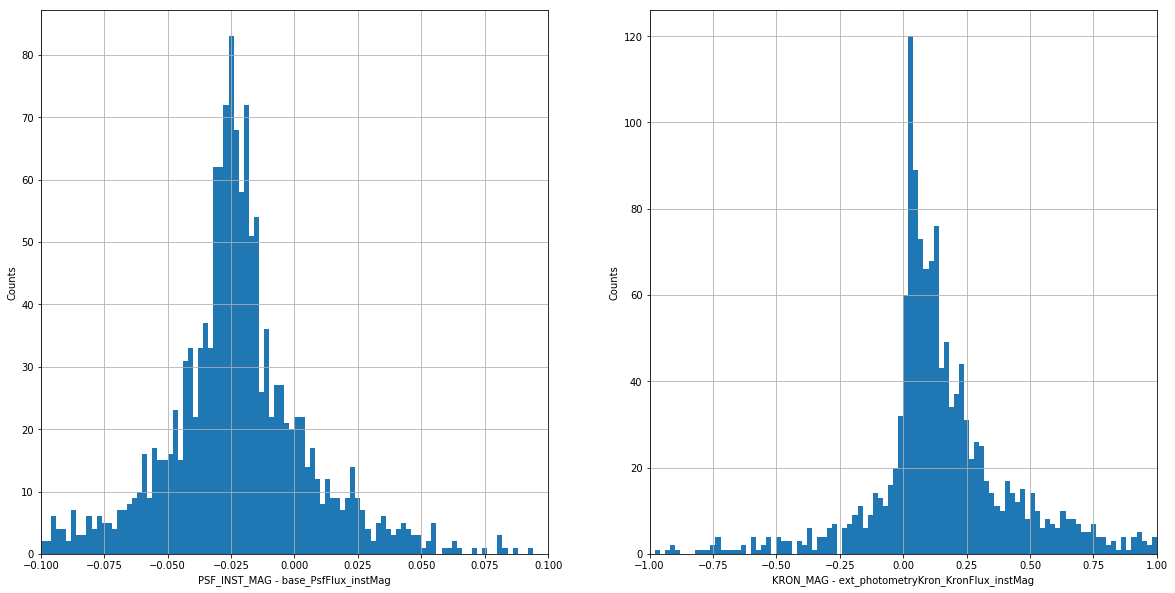

time: 717 ms


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
makeHistPlot(matched, 'PSF_INST_MAG', 'base_PsfFlux_instMag',  xlim=range1, fig=fig, ax=ax1)
makeHistPlot(matched, 'KRON_MAG', 'ext_photometryKron_KronFlux_instMag', xlim=[-1, 1], fig=fig, ax=ax2)
fig.show()

### Any trends with flux?

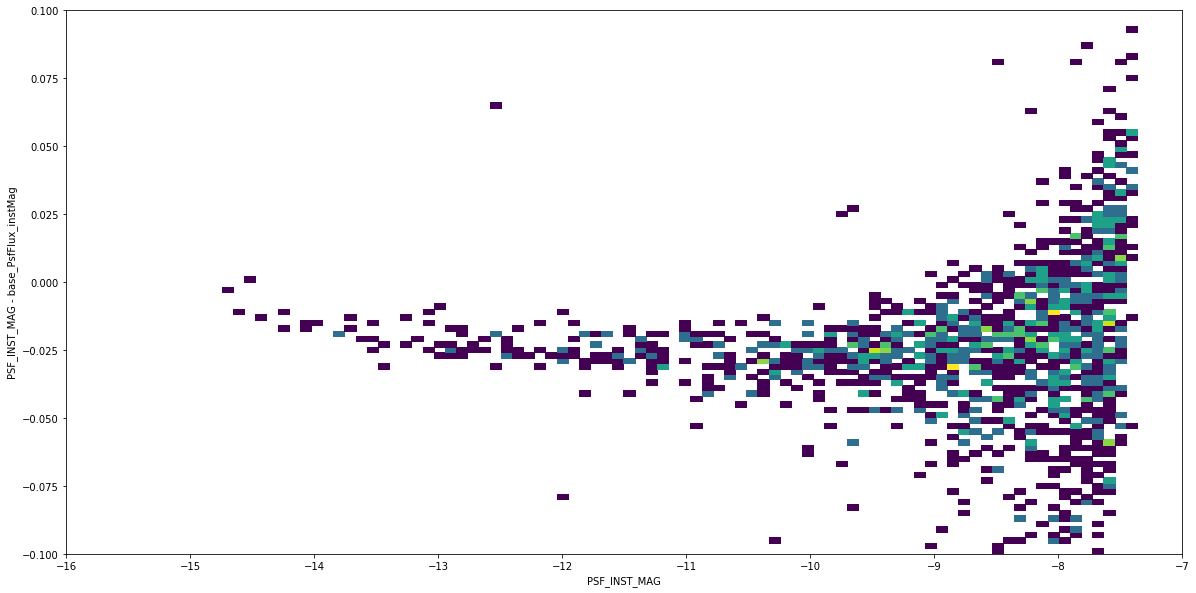

time: 421 ms


In [11]:
makeHist2DPlot(matched, 'PSF_INST_MAG', 'base_PsfFlux_instMag', 'PSF_INST_MAG', range=((-16, -7), range1),
               diff=True)

### Low density, repeat this with a full exposure:

In [12]:
matchedExp = pq2df(PROJ_DIR + "try1/matched/v0036408.pqt")
matchedExp['PSF_INST_MAG'] = -2.5 * np.log10(matchedExp['PSF_INST_FLUX'])
matchedExp['KRON_MAG'] = -2.5 * np.log10(matchedExp['KRON_FLUX'])

matchedExp['base_PsfFlux_instMag'] = -2.5 * np.log10(matchedExp['base_PsfFlux_instFlux'])
matchedExp['ext_photometryKron_KronFlux_instMag'] = -2.5 * np.log10(matchedExp['ext_photometryKron_KronFlux_instFlux'])

time: 343 ms


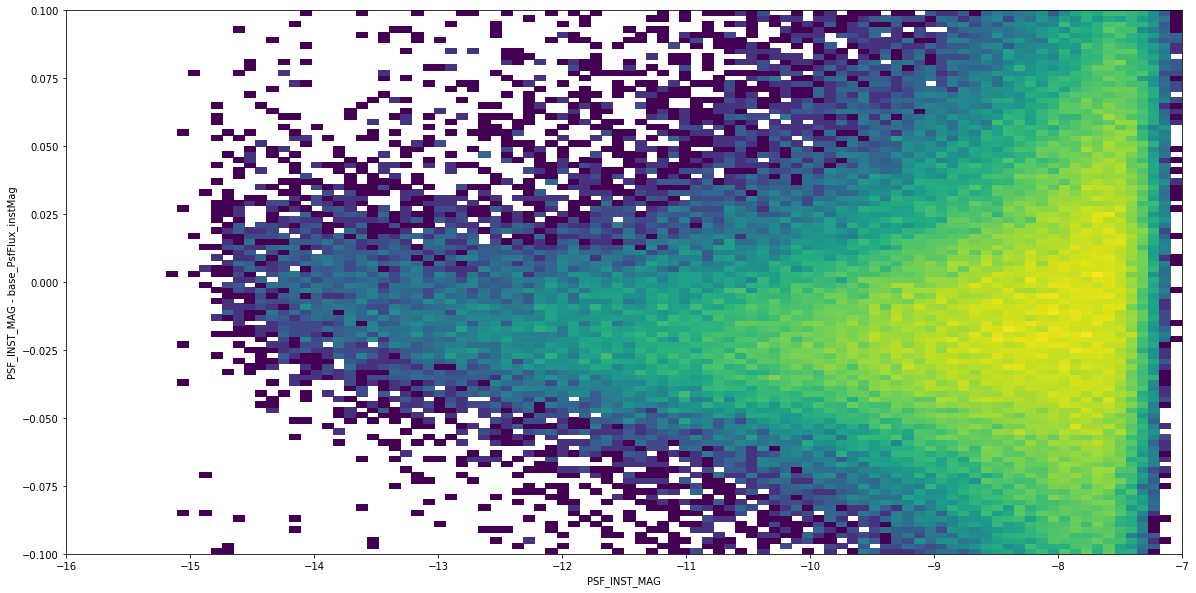

time: 485 ms


In [13]:
makeHist2DPlot(matchedExp, 'PSF_INST_MAG', 'base_PsfFlux_instMag', 'PSF_INST_MAG', range=((-16, -7), range1),
               diff=True)

### Continued curl up at bright end.  DRP slightly brighter at faint end?

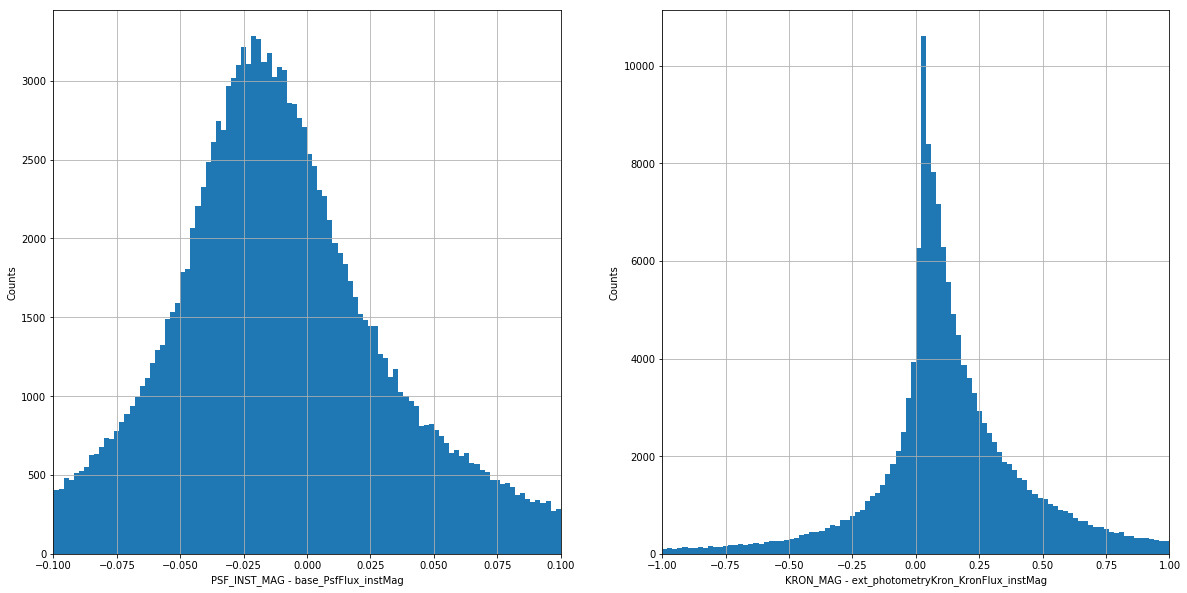

time: 733 ms


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
makeHistPlot(matchedExp, 'PSF_INST_MAG', 'base_PsfFlux_instMag',  xlim=range1, fig=fig, ax=ax1)
makeHistPlot(matchedExp, 'KRON_MAG', 'ext_photometryKron_KronFlux_instMag', xlim=[-1, 1], fig=fig, ax=ax2)
fig.show()

### Reinforces single chip results in the distribution of magnigude differences.
### As does the astrometric differences.

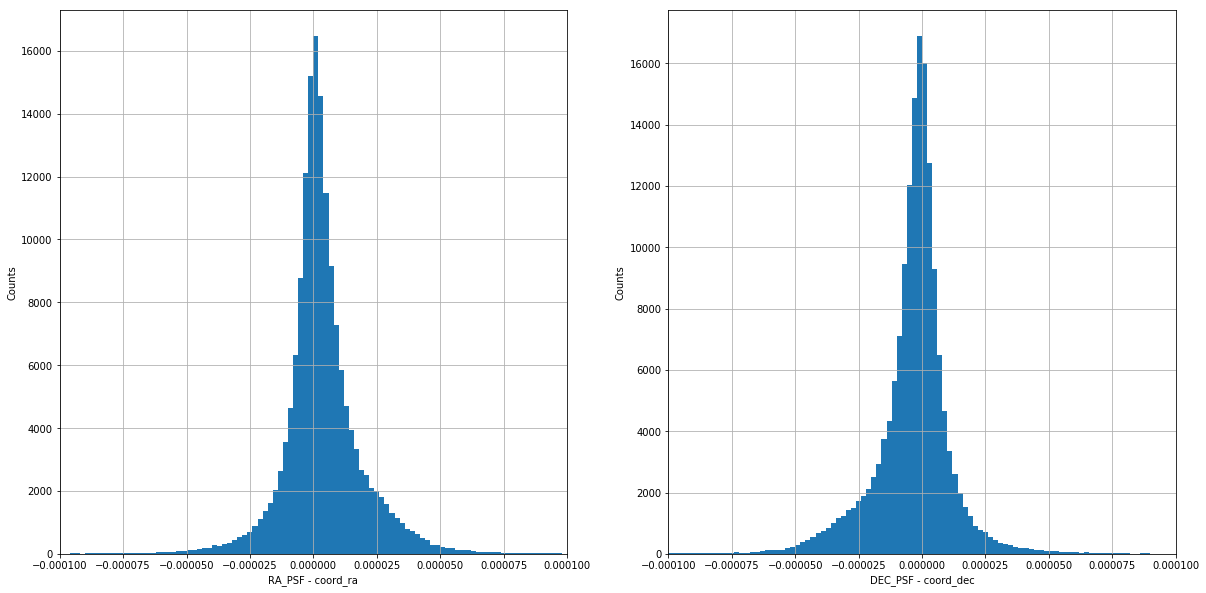

time: 690 ms


In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
makeHistPlot(matchedExp, 'RA_PSF', 'coord_ra', yf=(180.0 / np.pi), xlim=range4, fig=fig, ax=ax1)
makeHistPlot(matchedExp, 'DEC_PSF', 'coord_dec', yf=(180.0 / np.pi), xlim=range4, fig=fig, ax=ax2)
fig.show()

## Look at summary statistics for all exposures, all chips, all filters
 * Calculate `[0, 25, 50, 75, 100]`-percentile values for matched measurements
 * Group by exposureId, ccd, filter
 * Plotting median value comparisons for easier visualization.

In [16]:
SS = pq2df(PROJ_DIR + "sfm_ss.pqt")

time: 67.9 ms


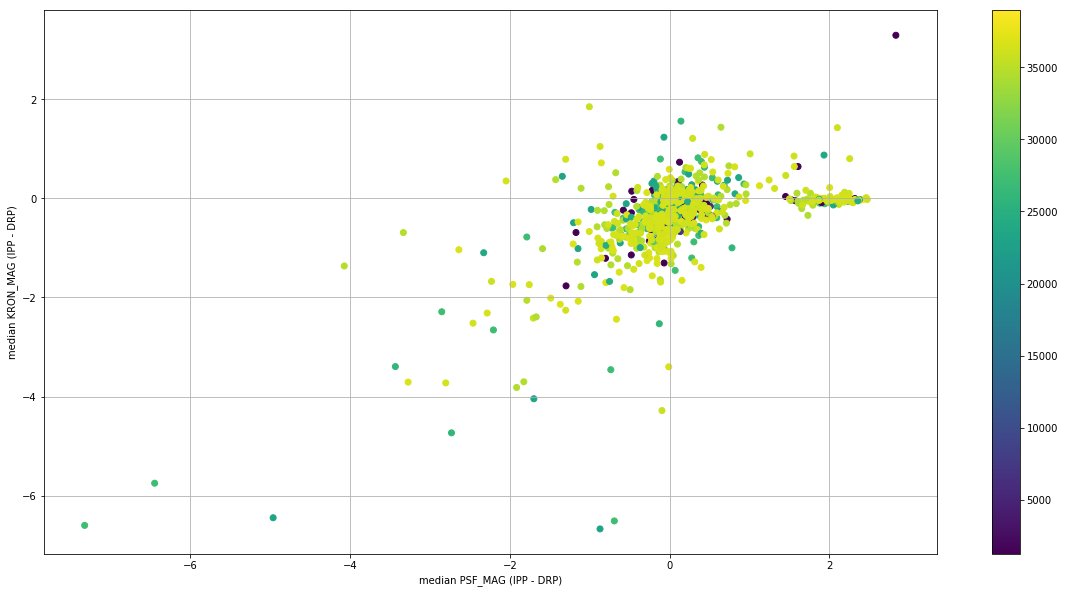

time: 1.44 s


In [17]:
cm = plt.scatter(SS['dM50'], SS['dK50'], c= SS['visit'])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("median PSF_MAG (IPP - DRP)")
plt.ylabel("median KRON_MAG (IPP - DRP)")
plt.show()

### Island of Kron magnitude equivalent, DRP 100x fainter objects?

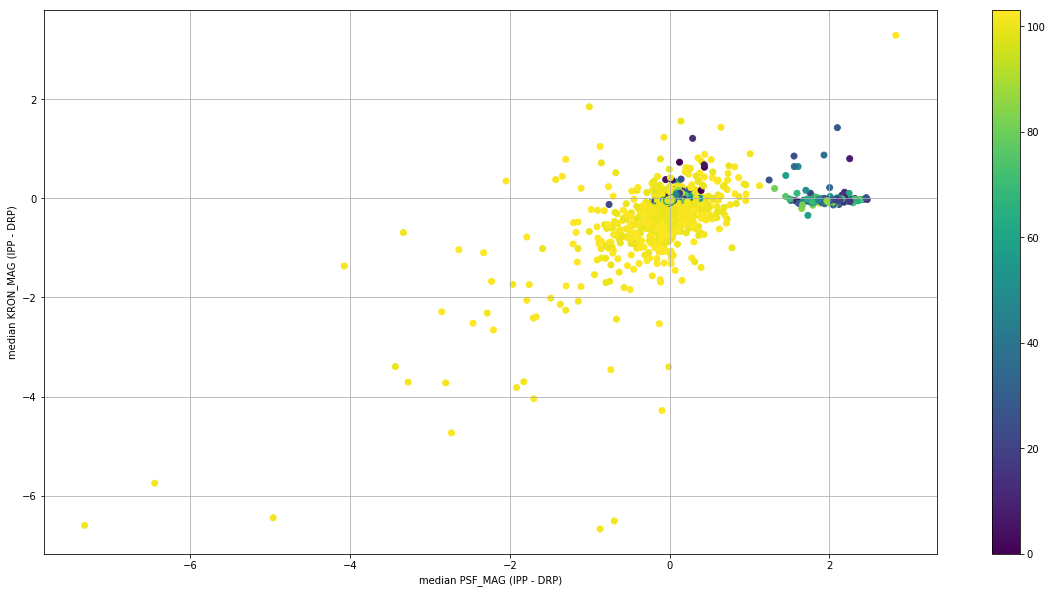

time: 1.45 s


In [18]:
cm = plt.scatter(SS['dM50'], SS['dK50'], c= SS['chip'])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("median PSF_MAG (IPP - DRP)")
plt.ylabel("median KRON_MAG (IPP - DRP)")
plt.show()

### Large yellow cloud points to edge chips contributing a large amount of the scatter.

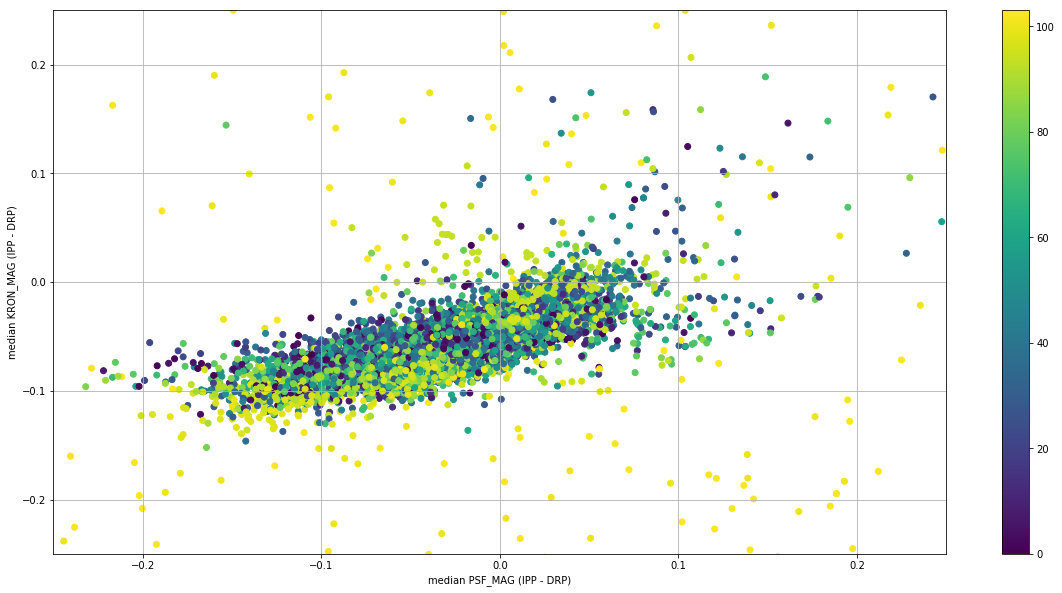

time: 1.52 s


In [19]:
cm = plt.scatter(SS['dM50'], SS['dK50'], c= SS['chip'])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("median PSF_MAG (IPP - DRP)")
plt.ylabel("median KRON_MAG (IPP - DRP)")
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.show()

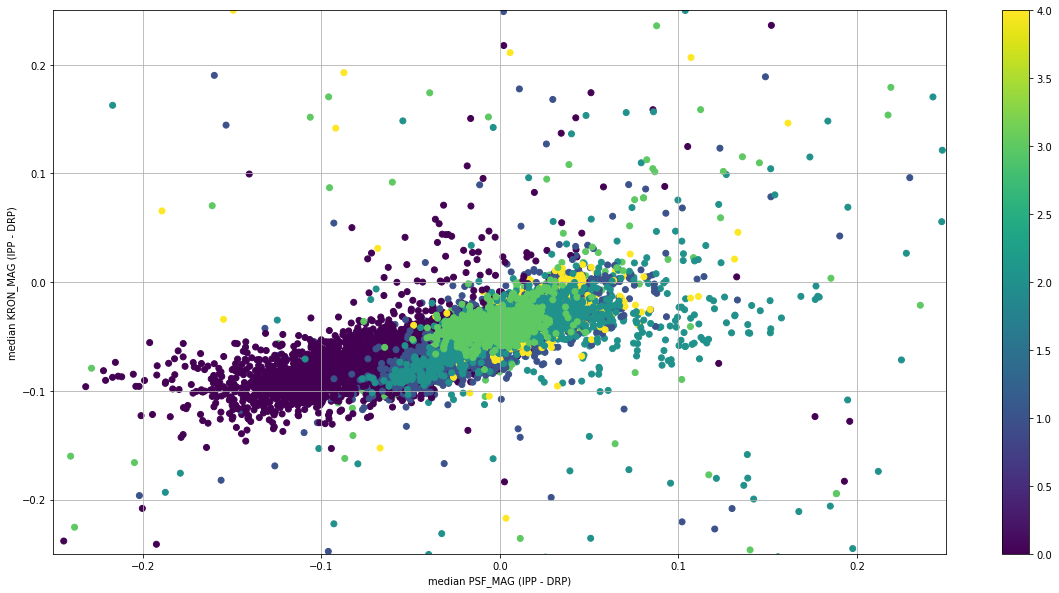

time: 1.37 s


In [20]:
filterMap = {'HSC-G': 0, 'HSC-R': 1, 'HSC-I': 2, 'HSC-Z': 3, 'HSC-Y': 4, 'NB0921': 5,
             'HSC-g': 0, 'HSC-r': 1, 'HSC-i': 2, 'HSC-z': 3, 'HSC-y': 4,
            }
cm = plt.scatter(SS['dM50'], SS['dK50'], c= [filterMap[x] for x in SS['filter'].values])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("median PSF_MAG (IPP - DRP)")
plt.ylabel("median KRON_MAG (IPP - DRP)")
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.show()

### Color dependence?

### Other parameters can be checked, this is just a first pass.

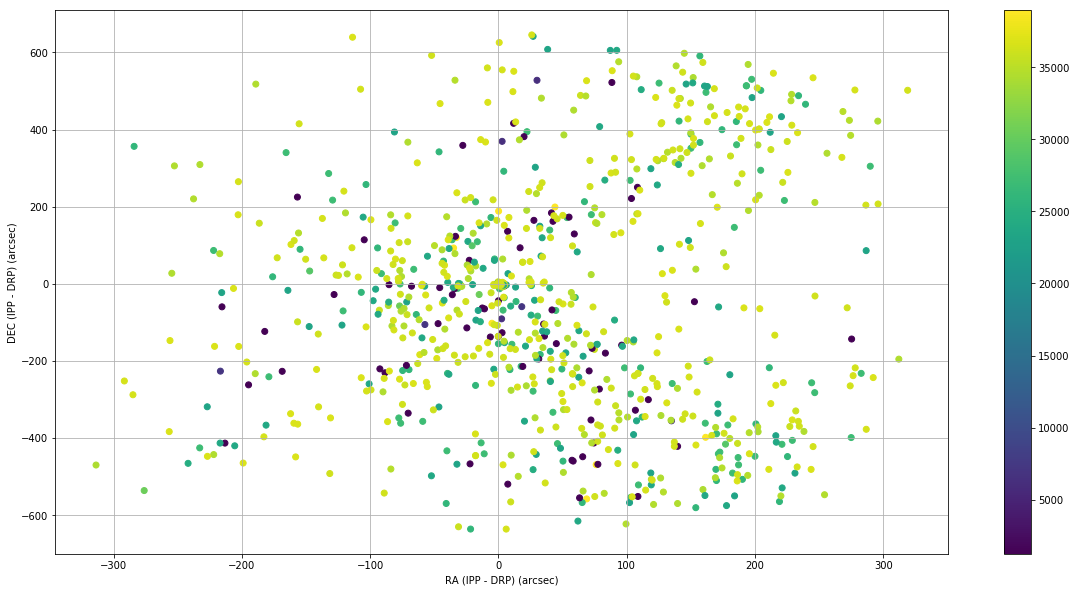

time: 1.45 s


In [21]:
cm = plt.scatter(SS['dR50'] * 3600, SS['dD50'] * 3600, c= SS['visit'])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("RA (IPP - DRP) (arcsec)")
plt.ylabel("DEC (IPP - DRP) (arcsec)")
plt.show()

### Edge chips again contribute a lot of the scatter.

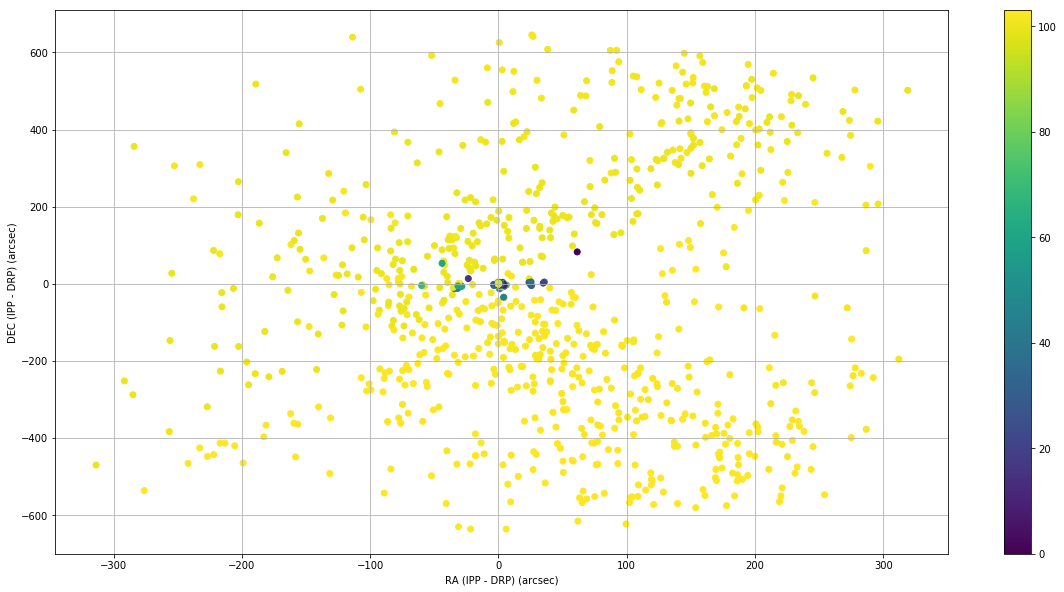

time: 1.16 s


In [22]:
cm = plt.scatter(SS['dR50'] * 3600, SS['dD50'] * 3600, c= SS['chip'])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("RA (IPP - DRP) (arcsec)")
plt.ylabel("DEC (IPP - DRP) (arcsec)")
plt.show()

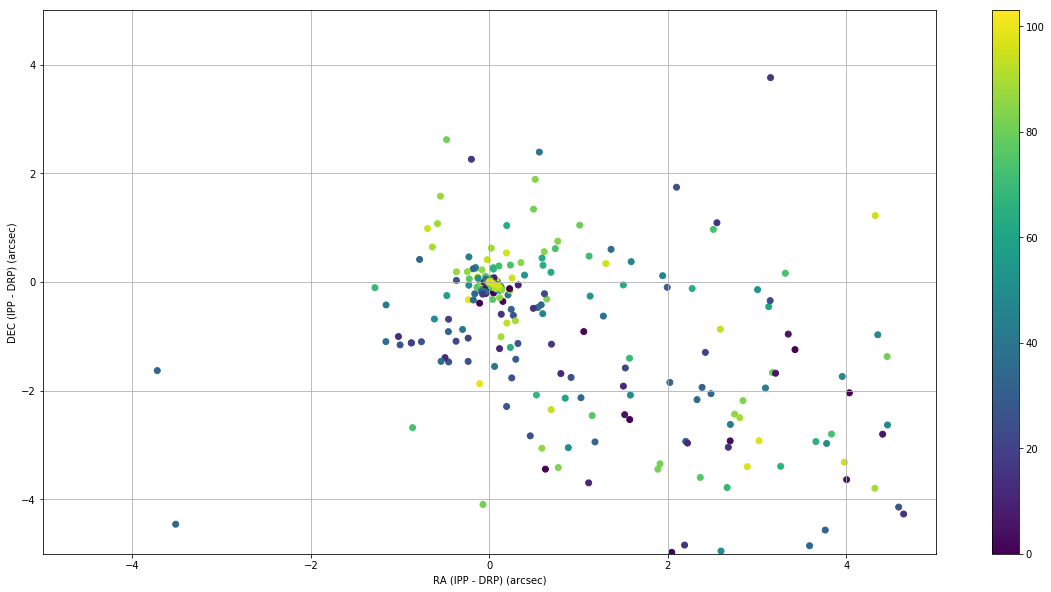

time: 1.26 s


In [23]:
cm = plt.scatter(SS['dR50'] * 3600, SS['dD50'] * 3600, c= SS['chip'])
plt.colorbar(cm)
plt.grid(True)
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("RA (IPP - DRP) (arcsec)")
plt.ylabel("DEC (IPP - DRP) (arcsec)")
plt.show()

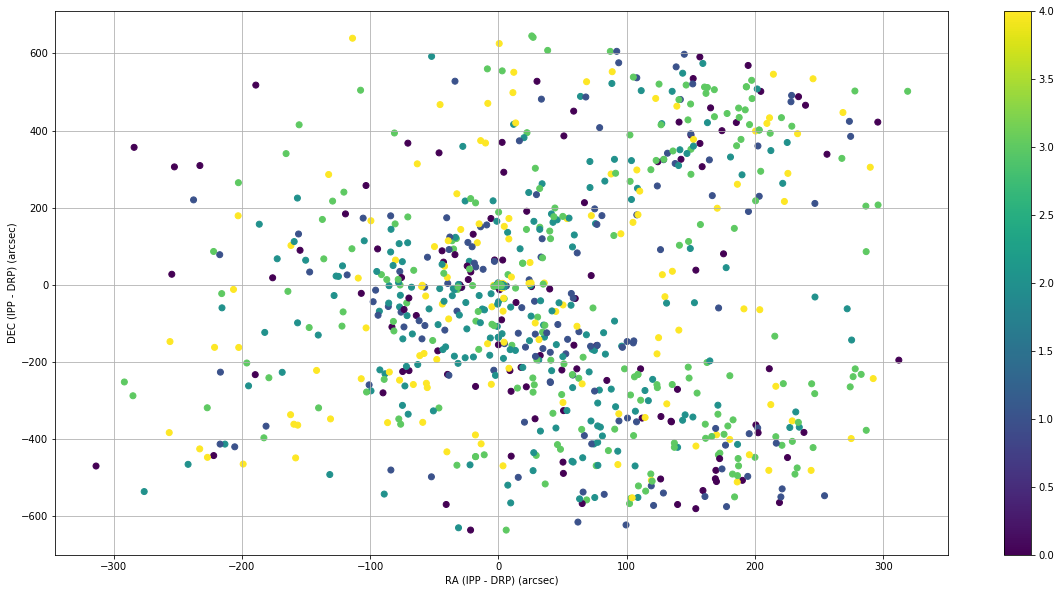

time: 1.19 s


In [24]:
cm = plt.scatter(SS['dR50'] * 3600, SS['dD50'] * 3600, c= [filterMap[x] for x in SS['filter']])
plt.colorbar(cm)
plt.grid(True)
plt.xlabel("RA (IPP - DRP) (arcsec)")
plt.ylabel("DEC (IPP - DRP) (arcsec)")
plt.show()

# Very preliminary stack/coadd comparisons.
 * DRP coadds look better, but missing regions have nInput=0?
 * Some of Sophie's "odd color" objects show up as defects/stacking issues/too few inputs.
 * Display WCS disagrees.  Astrowidgets issue?

In [25]:
IW_left = ImageWidget(use_opencv=False, image_height=500, image_width=500)
IW_left.maskColors['DETECTED'] = None
IW_right = ImageWidget(use_opencv=False, image_height=500, image_width=500)
Box = widgets.HBox(children=(IW_left, IW_right))
Box

time: 244 ms


In [26]:
drpCoadd = butler.get("deepCoadd", {'tract': 9615, 'patch': '7,7', 'filter': 'HSC-G'})
drpCoadd_nIm = butler.get("deepCoadd_nImage", {'tract': 9615, 'patch': '7,7', 'filter': 'HSC-G'})

time: 1.47 s


In [27]:
# IW_left.load_array(drpCoadd.image.getArray())
IW_left.load_lsst(drpCoadd)

time: 1.14 s


In [28]:
ippCoadd = PROJ_DIR + "czwRC2.wide.20200220/HSC.V0/skycell.1376.131/HSC.V0.skycell.1376.131.stk.5020.unconv.fits"
ippNumIm = ippCoadd.replace(".fits", ".num.fits")

time: 672 µs


In [29]:
IW_right.load_fits(ippCoadd)

time: 841 ms


## Number of input images:

In [30]:
IW_leftN = ImageWidget(use_opencv=False, image_height=500, image_width=500)
IW_leftN.maskColors['DETECTED'] = None
IW_rightN = ImageWidget(use_opencv=False, image_height=500, image_width=500)
BoxN = widgets.HBox(children=(IW_leftN, IW_rightN))
display(BoxN)
IW_leftN.load_lsst(drpCoadd_nIm)
IW_rightN.load_fits(ippNumIm)

time: 1.59 s


## Try to find a well populated set of coadds.
### Check what is part of the RC2 dataset.

In [31]:
drpSdb = pq2df(PROJ_DIR + "/drpSdb.pqt")
drpSdb.head()

,tract,patch,filter,RAmin,RAmax,DECmin,DECmax
0,9615,"0,0",HSC-G,216.944866,217.136137,-0.096085,0.095157
1,9615,"0,1",HSC-G,216.944893,217.136172,0.085868,0.281794
2,9615,"0,2",HSC-G,216.944921,217.136208,0.272496,0.468440
3,9615,"0,3",HSC-G,216.944948,217.136243,0.459135,0.655093
4,9615,"0,4",HSC-G,216.944976,217.136279,0.645779,0.841748


time: 16 ms


### Find the most complete IPP coadd:

In [32]:
ippSdb = pq2df(PROJ_DIR + "hsc_rc2.20200214/02a_dbselect.dat", sep='\t')
ippRow = ippSdb[ippSdb['state'] == 'full'].sort_values(['count(warp_id)', 'sum(good_frac)'],
                                                       ascending=False).head()
display(ippRow)
ippRow = ippRow.iloc[0]

,stack_id,filter,state,data_group,count(warp_id),sum(good_frac),skycell_id,radeg,decdeg,width,height
1538,6444,HSC-i,full,czwRC2.cosmos.20200220,24,11.375778,skycell.1359.140,149.900,1.49892,0.208333,0.208458
1539,6445,HSC-i,full,czwRC2.cosmos.20200220,22,5.598507,skycell.1359.141,149.700,1.49908,0.208333,0.208458
1543,6449,HSC-i,full,czwRC2.cosmos.20200220,20,6.087944,skycell.1359.162,149.500,1.69928,0.208333,0.208458
1464,6370,HSC-g,full,czwRC2.cosmos.20200220,17,15.489495,skycell.1360.239,150.099,2.29896,0.208333,0.208458
1469,6375,HSC-g,full,czwRC2.cosmos.20200220,17,15.483894,skycell.1360.259,150.099,2.49897,0.208333,0.208458


time: 21.3 ms


In [33]:
drpRow = drpSdb[(drpSdb['RAmin'] <= ippRow['radeg']) &
           (drpSdb['RAmax'] >= ippRow['radeg']) &
           (drpSdb['DECmin'] <= ippRow['decdeg']) &
           (drpSdb['DECmax'] >= ippRow['decdeg']) &
           (drpSdb['filter'].str.lower() == ippRow['filter'].lower())]
display(drpRow)
drpRow = drpRow.iloc[0]

,tract,patch,filter,RAmin,RAmax,DECmin,DECmax
811,9813,"6,0",HSC-I,149.776462,149.972469,1.391465,1.582748


time: 9.28 ms


In [34]:
IW_left2 = ImageWidget(use_opencv=False, image_height=500, image_width=500)
IW_left2.maskColors['DETECTED'] = None
IW_right2 = ImageWidget(use_opencv=False, image_height=500, image_width=500)
Box2 = widgets.HBox(children=(IW_left2, IW_right2))
Box2

time: 70.7 ms


## Display both:
 * CR remnants in IPP.
 * Different background areas.
 * Differences in edge definitions.

In [35]:
drpCoadd = butler.get("deepCoadd", {'tract': drpRow['tract'], 
                                    'patch': drpRow['patch'],
                                    'filter': drpRow['filter']})
ippCoadd = (PROJ_DIR + ippRow['data_group'] + 
            "/HSC.V0/" + ippRow['skycell_id'] + 
            "/HSC.V0." + ippRow['skycell_id'] + 
            ".stk." + str(ippRow['stack_id']) + ".unconv.fits")
IW_left2.load_lsst(drpCoadd)
IW_right2.load_fits(ippCoadd)

time: 3.14 s
